Взять датасет из google диска: https://drive.google.com/file/d/1MpWBFIbqu4mbiD0BBKYX6YhS-f4mN3Z_. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from scipy.stats import mannwhitneyu
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('marketing_campaign.csv')
df

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True
3,a1003,1/1/18,House Ads,personalization,English,True
4,a1004,1/1/18,House Ads,personalization,English,True
...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True
10033,a11033,1/17/18,Email,control,German,True
10034,a11034,1/5/18,Instagram,control,German,False
10035,a11035,1/17/18,Email,control,German,True


In [3]:
df.variant.value_counts()

control            5091
personalization    4946
Name: variant, dtype: int64

In [4]:
df.converted.value_counts()

False    8946
True     1076
Name: converted, dtype: int64

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
df['converted_1'] = np.where(df['converted'], 1, 0)
df[df['converted_1'] == 1] ['user_id'].count()

1091

In [7]:
df

,user_id,date_served,marketing_channel,variant,language_displayed,converted,converted_1
0,a1000,1/1/18,House Ads,personalization,English,True,1
1,a1001,1/1/18,House Ads,personalization,English,True,1
2,a1002,1/1/18,House Ads,personalization,English,True,1
3,a1003,1/1/18,House Ads,personalization,English,True,1
4,a1004,1/1/18,House Ads,personalization,English,True,1
...,...,...,...,...,...,...,...
10032,a11032,1/17/18,Email,control,German,True,1
10033,a11033,1/17/18,Email,control,German,True,1
10034,a11034,1/5/18,Instagram,control,German,False,0
10035,a11035,1/17/18,Email,control,German,True,1


In [8]:
df['converted_1'].value_counts()[1]/df['converted_1'].value_counts()[0]

0.12195394589760787

In [9]:
df = df.drop('converted', axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['converted_1'],axis=1), df['converted_1'], random_state=2, stratify=df['converted_1'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=2)

In [11]:
y_train.value_counts()[1]/y_train.value_counts()[0]

0.12070676990271988

In [12]:
y_test.value_counts()[1]/y_test.value_counts()[0]

0.12203844434510505

In [13]:
y_val.value_counts()[1]/y_val.value_counts()[0]

0.1255980861244019

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


class OHEEncoderBin(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        B = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        self.columns = B[:1]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
    
        return X[self.columns]  


class NumericPower(BaseEstimator, TransformerMixin):
    def __init__(self, key, p=2):
        self.key = key
        self.columns = []
        self.p = p+1

    def fit(self, X, y=None):
        B = [self.key + str(i) for i in range(1, self.p)]
        self.columns = B + ['log']
        return self

    def transform(self, X):
        Xp = X.values.reshape(-1,1)
        for i in range(2, self.p):
            Xp = np.hstack([Xp,(X.values.reshape(-1,1) ** i).astype(float)])

        Xp = np.hstack([Xp, np.log(X.values.reshape(-1,1) + 1).astype(float)])    
        B = pd.DataFrame(data = Xp, index = X.index, columns =[self.columns] )
        return B[self.columns]

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5645 entries, 8102 to 8525
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             5645 non-null   object
 1   date_served         5635 non-null   object
 2   marketing_channel   5635 non-null   object
 3   variant             5645 non-null   object
 4   language_displayed  5645 non-null   object
dtypes: object(5)
memory usage: 264.6+ KB


In [16]:
X_train.columns

Index(['user_id', 'date_served', 'marketing_channel', 'variant',
       'language_displayed'],
      dtype='object')

In [17]:
categorical_col =  ['marketing_channel', 'variant', 'language_displayed']

for i in categorical_col:
    print(i,' число уникальных значений: ', len(pd.unique(X_train[i])), 'уникальные значения', pd.unique(X_train[i]))

marketing_channel  число уникальных значений:  6 уникальные значения ['Instagram' 'Push' 'House Ads' 'Facebook' 'Email' nan]
variant  число уникальных значений:  2 уникальные значения ['personalization' 'control']
language_displayed  число уникальных значений:  4 уникальные значения ['English' 'Arabic' 'German' 'Spanish']


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

geography = Pipeline([
                ('selector', FeatureSelector(column='variant')),
                ('ohe', OHEEncoder(key='variant'))
            ])
geography.fit(X_train)
geography.transform(X_test).head(3)

,variant_control,variant_personalization
5973,1,0
3373,1,0
7229,0,1


In [19]:
final_transformers = list()

for cat_col in categorical_col:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

In [20]:
final_transformers

[('marketing_channel',
  Pipeline(steps=[('selector', FeatureSelector(column='marketing_channel')),
                  ('ohe', OHEEncoder(key='marketing_channel'))])),
 ('variant',
  Pipeline(steps=[('selector', FeatureSelector(column='variant')),
                  ('ohe', OHEEncoder(key='variant'))])),
 ('language_displayed',
  Pipeline(steps=[('selector', FeatureSelector(column='language_displayed')),
                  ('ohe', OHEEncoder(key='language_displayed'))]))]

In [21]:
feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state=42)),
])

In [22]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('marketing_channel',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='marketing_channel')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='marketing_channel'))])),
                                                ('variant',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='variant')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='variant'))])),
                                                ('language_displayed',
                                                 P

In [23]:
preds = pipeline.predict_proba(X_val)[:, 1]
preds[:10]

array([0.21033336, 0.05805324, 0.05664645, 0.21033336, 0.05805324,
       0.21033336, 0.92981674, 0.05100993, 0.21033336, 0.06227832])

In [24]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.172704, F-Score=0.354, Precision=0.252, Recall=0.595


Confusion matrix, without normalization
[[1300  372]
 [  85  125]]


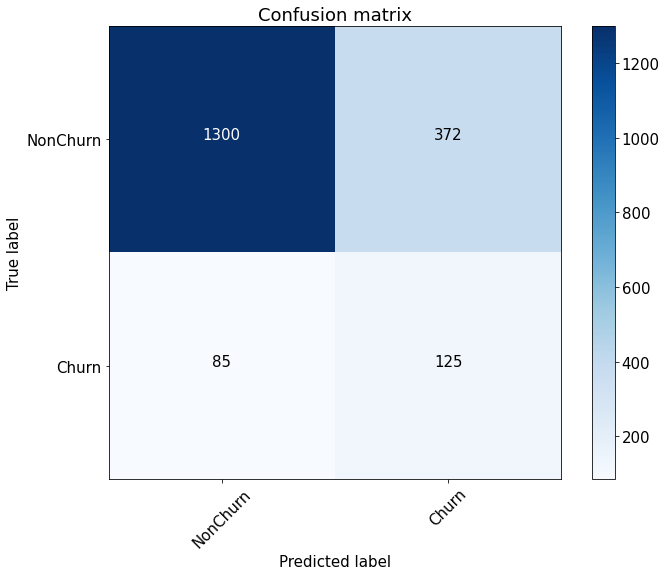

In [25]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds >= thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [26]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

C0 = (TP + FN) / np.sum(cnf_matrix)
C0

0.11158342189160468

In [27]:
X_test.shape

(2510, 5)

In [28]:
X_A, X_B, y_A, y_B = train_test_split(X_test, y_test, test_size=0.5, random_state=2, stratify=y_test)

In [29]:
predsB = pipeline.predict_proba(X_B)[:, 1]
cnf_matrix = confusion_matrix(y_B, predsB > thresholds[ix])

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]
print(cnf_matrix)

[[857 262]
 [ 64  72]]


In [30]:
churn_ef = 0.5
C0_A = (np.sum(y_A)) / y_A.shape[0] 
print(C0_A)


C1_MLB = (FN + (1-churn_ef) * TP) / np.sum(cnf_matrix)
print(C1_MLB)

0.10916334661354582
0.0796812749003984


In [31]:
y_churnA = y_A  

y_pred = (predsB > thresholds[ix]) 
ind_churn = np.where((y_pred != y_B) & (y_B == 1))
y_churnB = np.zeros(y_B.shape) 
y_churnB[ind_churn] = 1


k1, n1 = np.sum(y_A), y_A.shape[0]
k2, n2 = np.sum(y_churnB), y_churnB.shape[0]
k1, k2, n1, n2

(137, 64.0, 1255, 1255)

In [32]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]))

print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=5.368 pvalue=0.000


In [33]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([k1, k2]), 
                                                        np.array([n1, n2]))

print(f'Results are chisq={chisq:.3f} pvalue={pvalue:.3f}')

Results are chisq=28.820 pvalue=0.000
